In [31]:
#Importing all the necessary Libraries`
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, median_absolute_error, mean_absolute_error
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import scipy
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
#setting figure size for future visualizations
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style('white')
import warnings
warnings.filterwarnings("ignore")
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % np.random.randint(60, 100)
import nltk
nltk.download('stopwords')
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
#reading the dataset and assigning to the variable df
df = pd.read_csv('/content/drive/MyDrive/USL/AB_NYC_2019.csv' )

### First 5 rows of the Dataset

In [34]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [35]:
#number of rows and columns
print('number of rows equals to {} '.format(df.shape[0]))
print('number of columns equals to {}'.format(df.shape[1]))

number of rows equals to 48895 
number of columns equals to 16


In [36]:
#set of columns that have missing valueswith percentage of missing values
missing_df = df.isnull().sum()/len(df)*100
missing_df[(missing_df!=0.000000)]

name                  0.032723
host_name             0.042949
last_review          20.558339
reviews_per_month    20.558339
dtype: float64

In [37]:
#columns of missing values
null_cols = missing_df[(missing_df!=0.000000)].index
null_cols

Index(['name', 'host_name', 'last_review', 'reviews_per_month'], dtype='object')

In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,48895.0,1.901714e+07,1.098311e+07,2539.00000,9.471945e+06,1.967728e+07,2.915218e+07,3.648724e+07
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48895.0,7.143982e+00,3.295252e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


In [39]:
#check the data types and check if any columns are of different data types that you would expect
#check the missing values for every column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

We have missing values in the name and host_name columns, but the id and host_id there're no missing values, so in our investigation, I will depend on the id's columns.

The last review column also has missing values, so I will drop it later because, I will not use it.

The reviews per month column has missing values,I will deal with it later.

In [40]:
#discover the number of unique values for categorical columns
catg_cols = df.select_dtypes('O')
for i in catg_cols:
    print(i,':')
    print(df[i].nunique())
    print('\n')

name :
47905


host_name :
11452


neighbourhood_group :
5


neighbourhood :
221


room_type :
3


last_review :
1764




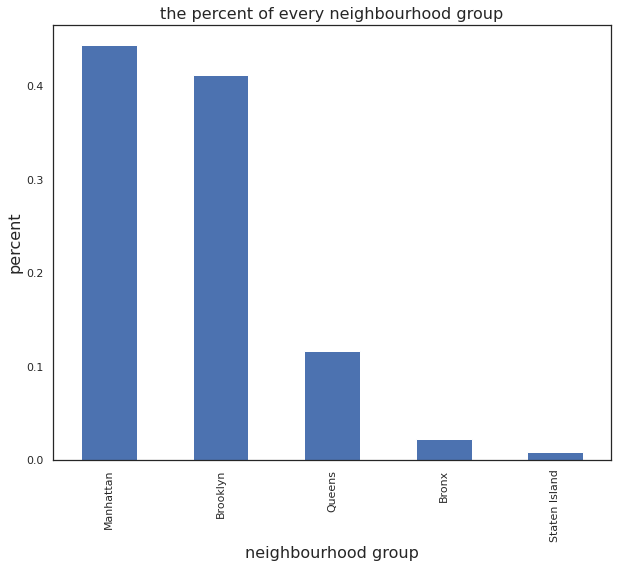

In [41]:
#visualize the categorical values for the neighbourhood_group
count_neigh = df.neighbourhood_group.value_counts(normalize=True).plot(kind='bar')
plt.title('the percent of every neighbourhood group', fontsize = 16)
plt.ylabel('percent', fontsize = 16)
plt.xlabel('neighbourhood group', fontsize = 16)
plt.show()

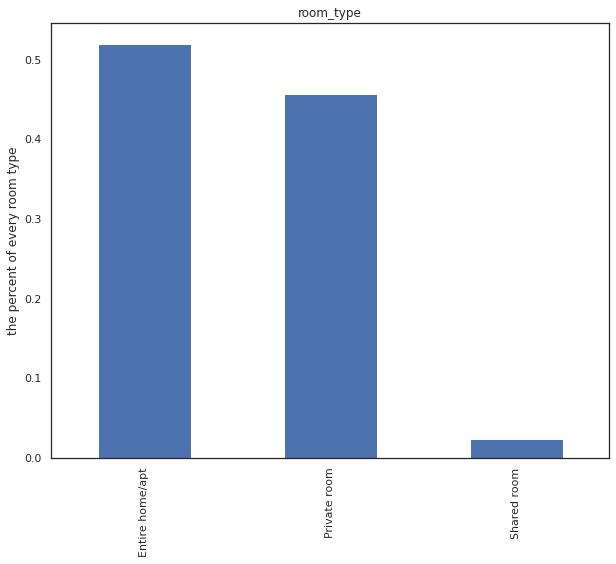

In [42]:
#visualize the categorical values for the room_type
count_room = df.room_type.value_counts(normalize=True).plot(kind='bar')
plt.title('room_type')
plt.ylabel('the percent of every room type')
plt.show()

In [43]:
#let's see what hosts (IDs) have the most listings on Airbnb platform and taking advantage of this service
top_host=df.host_id.value_counts().head(10)
top_host_df=pd.DataFrame(top_host)
top_host_df.reset_index(inplace=True)
top_host_df.rename(columns={'index':'Host_ID', 'host_id':'P_Count'}, inplace=True)
top_host_df

,Host_ID,P_Count
0,219517861,327
1,107434423,232
2,30283594,121
3,137358866,103
4,12243051,96
5,16098958,96
6,61391963,91
7,22541573,87
8,200380610,65
9,7503643,52


In [44]:
#coming back to our dataset we can confirm our fidnings with already existing column called 'calculated_host_listings_count'
top_host_check=df.calculated_host_listings_count.max()
top_host_check

327

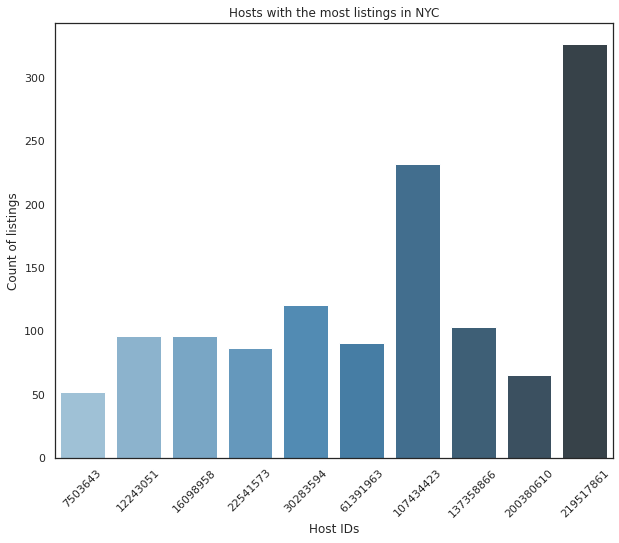

In [45]:
sns.barplot(x="Host_ID", y="P_Count", data=top_host_df,
                 palette='Blues_d')
plt.title('Hosts with the most listings in NYC')
plt.ylabel('Count of listings')
plt.xlabel('Host IDs')
plt.xticks(rotation=45)
plt.show()

In [46]:
#price distributions for each neighbourhood_group
df.groupby('neighbourhood_group')['price'].describe().iloc[:,3:]

,min,25%,50%,75%,max
neighbourhood_group,,,,,
Bronx,0.0,45.0,65.0,99.0,2500.0
Brooklyn,0.0,60.0,90.0,150.0,10000.0
Manhattan,0.0,95.0,150.0,220.0,10000.0
Queens,10.0,50.0,75.0,110.0,10000.0
Staten Island,13.0,50.0,75.0,110.0,5000.0


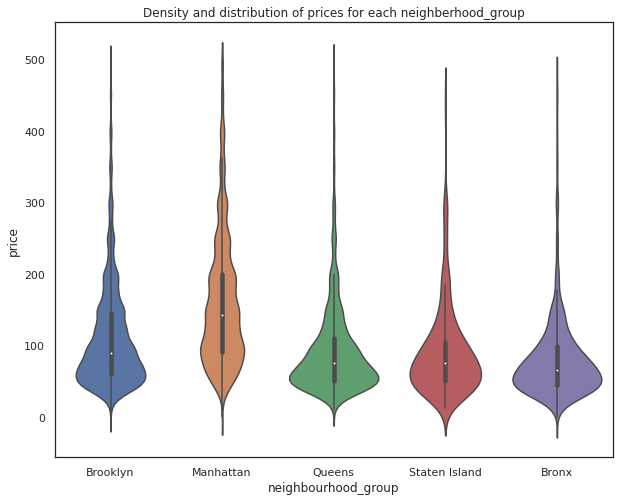

In [47]:
#we can see from our statistical table that we have some extreme values, therefore we need to remove them for the sake of a better visualization

#creating a sub-dataframe with no extreme values / less than 500
ext=df[df.price < 500]
#using violinplot to showcase density and distribtuion of prices 
sns.violinplot(data=ext, x='neighbourhood_group', y='price')
plt.title('Density and distribution of prices for each neighberhood_group')
plt.show()

Manhattan has the highest range of prices for the listings with 150 dollar price as average observation, followed by Brooklyn with 90 dollar per night. Queens and Staten Island appear to have very similar distributions, Bronx is the cheapest of them all.

In [48]:
#as we saw earlier from unique values for neighbourhood there are way too many to concentrate on;
#therefore, let's grab just top 10 neighbourhoods that have the most listings in them

#finding out top 10 neighbourhoods
df.neighbourhood.value_counts().head(10)

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Hell's Kitchen        1958
East Village          1853
Upper East Side       1798
Crown Heights         1564
Midtown               1545
Name: neighbourhood, dtype: int64

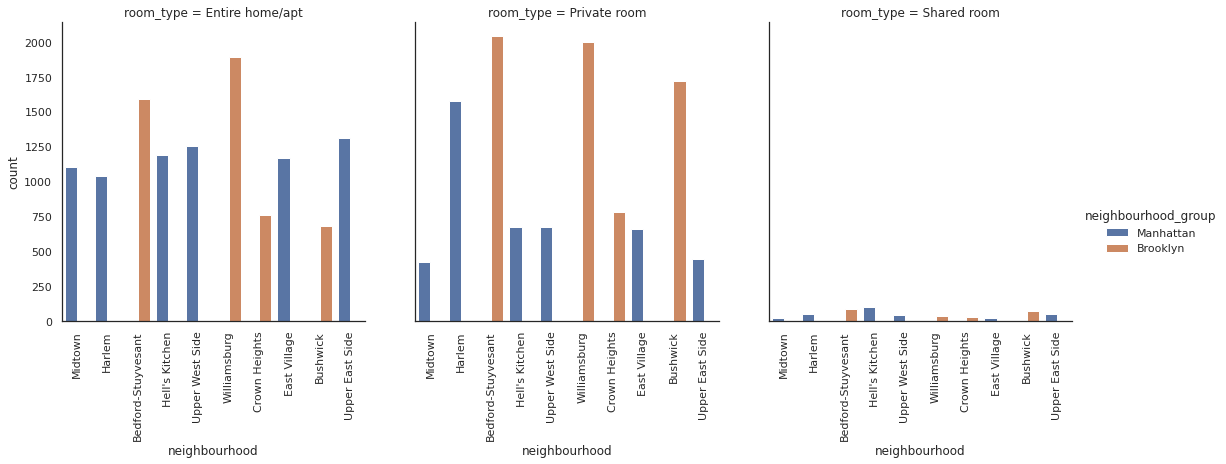

In [49]:
#let's now combine this with our boroughs and room type for a rich visualization we can make

#grabbing top 10 neighbourhoods for sub-dataframe
sub=df[df['neighbourhood'].isin(['Williamsburg','Bedford-Stuyvesant','Harlem','Bushwick',
                 'Upper West Side','Hell\'s Kitchen','East Village','Upper East Side','Crown Heights','Midtown'])]
a = sns.catplot(x='neighbourhood',hue='neighbourhood_group',col='room_type',data=sub,kind='count')
a.set_xticklabels(rotation=90)
plt.show()

We can see that our plot consists of 3 subplots with such output, we can easily proceed with comparing distributions among interesting attributes. Y and X axes stay exactly the same for each subplot, Y-axis represents a count of observations and X-axis observations we want to count. However, there are 2 more important elements: column and hue; those 2 differentiate subplots. After we specify the column and determined hue we are able to observe and compare our Y and X axes among specified column as well as color-coded. So, what do we learn from this? The observation that is definitely contrasted the most is that 'Shared room' type Airbnb listing is barely available among 10 most listing-populated neighborhoods. Then, we can see that for these 10 neighborhoods only 2 boroughs are represented: Manhattan and Brooklyn; that was somewhat expected as Manhattan and Brooklyn are one of the most traveled destinations, therefore would have the most listing availability. We can also observe that Bedford-Stuyvesant and Williamsburg are the most popular for Manhattan borough, and Harlem for Brooklyn.

In [50]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


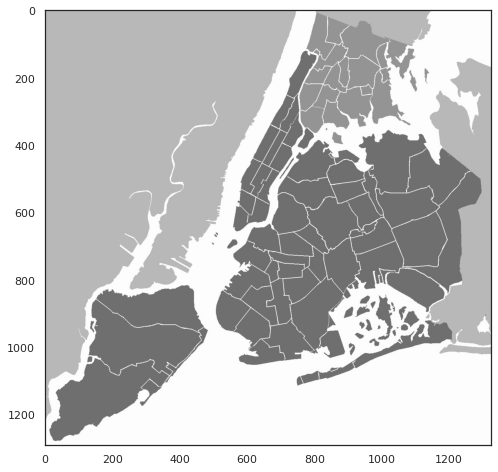

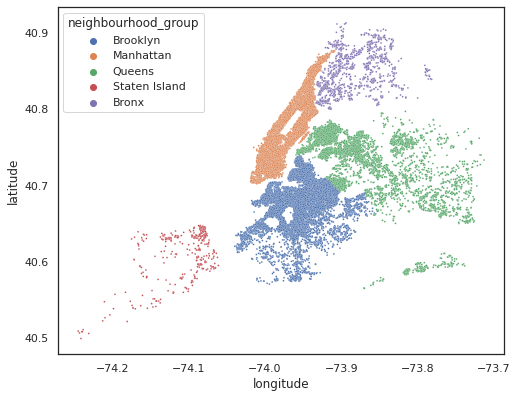

In [51]:
# to read the image stored in the working directory
data = cv2.imread('/content/drive/MyDrive/USL/New_York_City_.png')
  

plt.imshow(data)

plt.figure(figsize=(8,8))
sns.scatterplot(df['longitude'],df['latitude'],s=3,hue=df['neighbourhood_group'])
plt.axis('scaled')
#plt.axis('off')
plt.show()

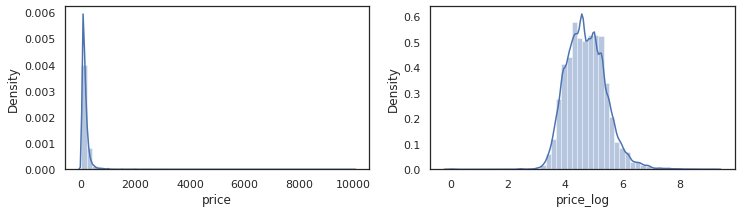

In [52]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
sns.distplot(df['price'], ax=axes[0])
df['price_log'] = df['price'].apply(np.log1p)
sns.distplot(df['price_log'], ax=axes[1])
plt.show()

Our prediction target is going to be price. We can see that the distribution is quite skewed, so the logarithm will be a better target.

In [53]:
#Dropping Price column as we or target variable is price_log henceforth
df = df.drop('price',axis=1)

In [54]:
#We will drop last review as it is a date column and we cannot impute the missing values with anything
df = df.drop('last_review',axis=1)

In [55]:
#filling the reviews per month with 0 value
df['reviews_per_month'].fillna(0,inplace = True)

In [56]:
wordnet=WordNetLemmatizer()

stops = set(stopwords.words('english')) #english stopwords

def review_to_words(raw_review):
    # 1. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', raw_review)
    # 2. lower letters
    words = letters_only.lower().split()
    # 3. Stopword
    non_stop_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [wordnet.lemmatize(w) for w in non_stop_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [57]:
aa = df['name'].dropna().apply(review_to_words)

In [58]:
comment_words = ''
for val in aa:
    # split the value
    tokens = val.split()
    comment_words += " ".join(tokens)+" "

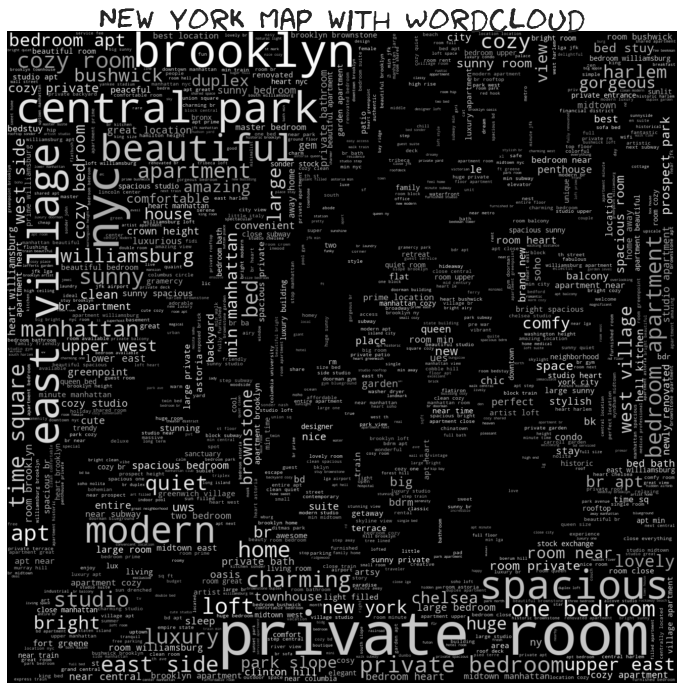

In [60]:
mask = np.array(Image.open("/content/drive/MyDrive/USL/New_York_City_.png"))
wordcloud_por = WordCloud(background_color="black", max_words=1000, mask=mask).generate(comment_words)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12,12])
plt.imshow(wordcloud_por.recolor(color_func=grey_color_func), interpolation="bilinear")
plt.axis("off")

plt.title('New York Map with WordCloud',{"fontname":"fantasy", "fontweight":"bold", "fontsize":"30"})
plt.savefig("wordcloud_nyc_map.png", format="png")

We can observe 'private room','brooklyn','beautiful','central park' etc as most used in name feature

In [61]:
# Drop unwanted columns
df.drop('id', axis=1, inplace=True)
df.drop('name', axis=1, inplace=True)
df.drop('host_id', axis=1, inplace=True)
df.drop('host_name', axis=1, inplace=True)
df.drop('number_of_reviews', axis=1, inplace=True)
df.drop('reviews_per_month', axis=1, inplace=True)

In [62]:
# Remove price = 0
df = df[df.price_log > 0].copy()

In [63]:
# Standardize ratio attributes
df[['latitude', 'longitude', 'minimum_nights', 'calculated_host_listings_count', 'availability_365']] = StandardScaler().fit_transform(df[['latitude', 'longitude','minimum_nights', 'calculated_host_listings_count', 'availability_365']])

In [64]:
# One hot encoding for the categorical features
neighbourhood_group_dummies = pd.get_dummies(df['neighbourhood_group'], prefix="is_group")
room_type_dummies = pd.get_dummies(df['room_type'], prefix="is_room")
neighbourhood_dummies = pd.get_dummies(df['neighbourhood'], prefix="is_neighbourhood")
df1 = pd.concat([df[['minimum_nights','calculated_host_listings_count',
       'availability_365']], room_type_dummies, neighbourhood_group_dummies, neighbourhood_dummies, df[['price_log']]], axis=1)

In [65]:
# Principle Component Analysis
X = df1.copy().drop('price_log', axis=1)
X.reset_index(drop=True)
y = df1['price_log']

print(X.shape, y.shape)
pca = PCA()
pca.fit(X)

cutoff_variance = 0.95
cutoff = 0
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
for i in range(len(cumulative_variance)):
    if cumulative_variance[i] > cutoff_variance:
        cutoff = i
        break
        
print('cutoff =', cutoff)

pca = PCA(n_components=cutoff)
pcaX = pca.fit_transform(X)
pcaX.shape

# get the training and testing sets (PCA)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(pcaX, y, test_size=0.2, random_state=100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(48884, 232) (48884,)
cutoff = 35
(39107, 35) (9777, 35) (39107,) (9777,)


In [66]:
rows = []

train_preds = []
test_preds = []



models = [XGBRegressor(objective='reg:squarederror'), LinearRegression(), Ridge(), Lasso(alpha=1e-4), RandomForestRegressor()]
       
for i in models:
    
    i.fit(X_train, y_train)
    
    y_train_pred = i.predict(X_train)
    train_preds.append(y_train_pred)
    
    y_pred = i.predict(X_test)
    test_preds.append(y_pred)
    
    rows.append([np.sqrt(mean_squared_error(y_test, y_pred)),
               r2_score(y_test, y_pred),
               mean_absolute_error(y_test, y_pred),
               np.sqrt(mean_squared_error(y_train, y_train_pred)),
               r2_score(y_train, y_train_pred),
               mean_absolute_error(y_train, y_train_pred)])

In [67]:
table = pd.DataFrame(rows, columns=['Test RMSE', 'Test R2', 'Test MeanAE', 'Train RMSE', 'Train R2', 'Train MeanAE'])
table

,Test RMSE,Test R2,Test MeanAE,Train RMSE,Train R2,Train MeanAE
0,0.450546,0.564339,0.329048,0.460343,0.560050,0.331212
1,0.468726,0.528471,0.342299,0.483502,0.514671,0.347726
2,0.468727,0.528470,0.342300,0.483502,0.514670,0.347723
3,0.468762,0.528398,0.342335,0.483520,0.514635,0.347686
4,0.455898,0.553928,0.328241,0.282882,0.833870,0.187103


####################### TRAINING SET #######################


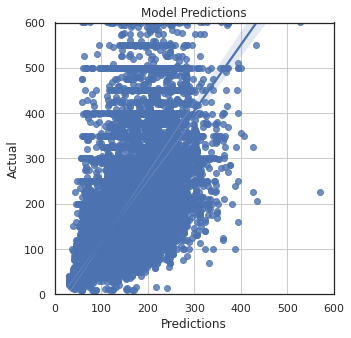

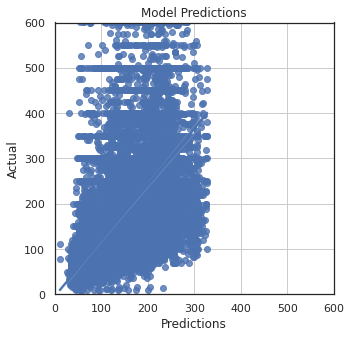

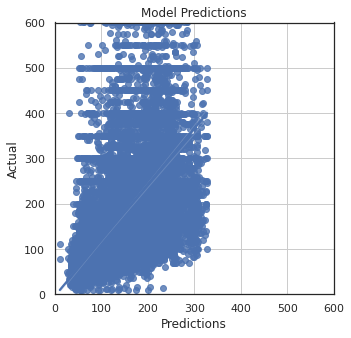

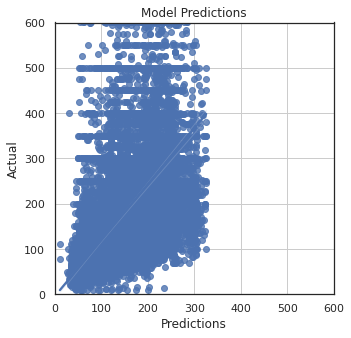

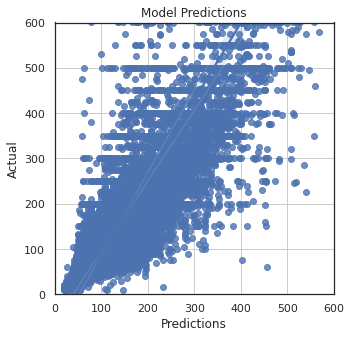

####################### TESTING SET #######################


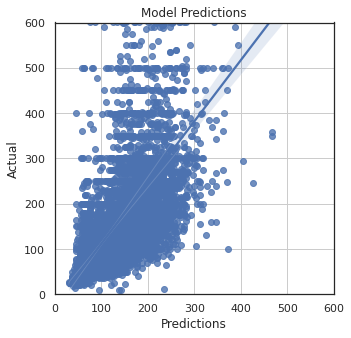

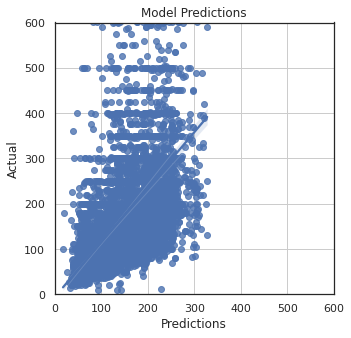

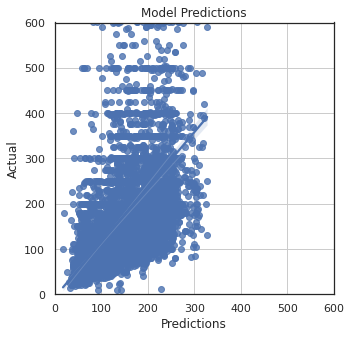

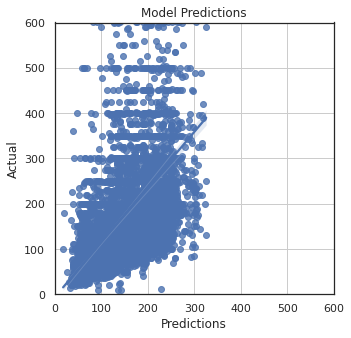

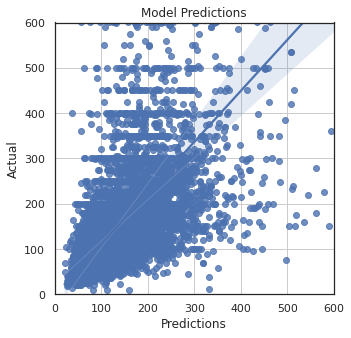

In [68]:
print('####################### TRAINING SET #######################')

for i in range(len(train_preds)):
    
    y_pred_inv = [np.expm1(x) for x in train_preds[i]]
    y_train_inv = [np.expm1(x) for x in y_train]

    plt.figure(figsize=(5,5))
    sns.regplot(y_pred_inv, y_train_inv)
    plt.ylabel('Actual')
    plt.xlabel('Predictions')
    plt.title("Model Predictions")
    plt.xlim(0, 600)
    plt.ylim(0, 600)
    plt.grid(True)
    plt.show()

print('####################### TESTING SET #######################')

for i in range(len(test_preds)):
    
    y_pred_inv = [np.expm1(x) for x in test_preds[i]]
    y_test_inv = [np.expm1(x) for x in y_test]

    plt.figure(figsize=(5,5))
    sns.regplot(y_pred_inv, y_test_inv)
    plt.ylabel('Actual')
    plt.xlabel('Predictions')
    plt.title("Model Predictions")
    plt.xlim(0, 600)
    plt.ylim(0, 600)
    plt.grid(True)
    plt.show()

8.987321812850125 2.3978952727983707
9777 9777 9777
3.759848638379518 -2.9808354614180543


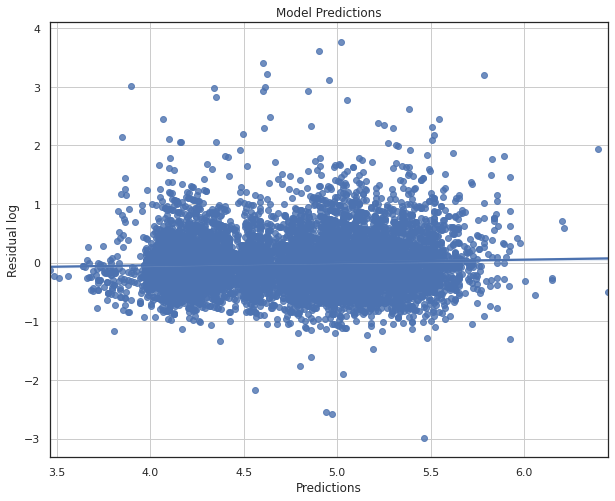

In [69]:

# residual plots

print(y_test.max(), y_test.min())
residual = []
for a, p in zip(y_test, test_preds[0]):
    residual.append(a - p)
print(len(y_test), len(test_preds[0]), len(residual))
print(max(residual), min(residual))
#     plt.figure(figsize=(16,8))
sns.regplot(test_preds[0], residual)
plt.ylabel('Residual log')
plt.xlabel('Predictions')
plt.title("Model Predictions")
# plt.xlim(0, 600)
# plt.ylim(0, 600)
plt.grid(True)
plt.show()

In [70]:

scores = {}

def cross_validation_evaluator(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=45)
    r2 = make_scorer(mean_squared_error)
    cv_score = cross_val_score(model, X, y, cv=cv, scoring=r2)
    print('done!')
    return cv_score.mean()

linearRegressionModel = LinearRegression()
ridgeModel = Ridge()
lassoModel = Lasso(alpha=1e-4)
huberRegressionModel = HuberRegressor()
randomForestModel = RandomForestRegressor()
xgboostModel = XGBRegressor(objective='reg:squarederror')
decisionTreeModel = DecisionTreeRegressor()

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)

scores['linear'] = cross_validation_evaluator(linearRegressionModel, X_tr, y_tr)
scores['ridge'] = cross_validation_evaluator(ridgeModel, X_tr, y_tr)
scores['lasso'] = cross_validation_evaluator(lassoModel, X_tr, y_tr)
scores['randomforest'] = cross_validation_evaluator(randomForestModel, X_tr, y_tr)
scores['xgboost'] = cross_validation_evaluator(xgboostModel, X_tr, y_tr)
scores['decisionTree'] = cross_validation_evaluator(decisionTreeModel, X_tr, y_tr)

done!
done!
done!
done!
done!
done!


In [71]:
scores

{'decisionTree': 0.33564574180375684,
 'lasso': 0.23480910068467548,
 'linear': 0.23480437613353766,
 'randomforest': 0.22646226602895267,
 'ridge': 0.23480309209905256,
 'xgboost': 0.2208838496333681}